# Final Project — NYC 311 Residential Noise Complaints (2019–2024)

### Dataset(s) to be used:
NYC 311 Service Requests (2010–Present)  
https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

### Analysis question:
Has the frequency of “Noise – Residential” complaints increased over the past five years (2019–2024), and does the increase differ by borough?

### Columns that might be used:
- `Created Date`
- `Complaint Type`
- `Descriptor`
- `Borough`
- `Incident Zip`
- `Latitude`
- `Longitude`

### Hypothesis:
“Noise – Residential” complaints have increased significantly since 2019, with Manhattan experiencing the largest growth rate due to population density and multi-unit residential buildings.

## 1. Imports and global settings

In this section, I import the Python libraries that I will use throughout the analysis and set some global display options.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import requests


## 2. Load the NYC 311 “Noise - Residential” data via API
Instead of downloading the entire 311 dataset, I use the NYC Open Data API
to fetch only the rows that match my research question:

- complaints where `complaint_type = "Noise - Residential"`, and  
- the years 2019–2024,  

it is more efficient to use the NYC Open Data API to retrieve only the data
needed for analysis.


In [6]:
BASE_URL = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

params = {
    # year, borough, and number of rows
    "$select": "date_extract_y(created_date) as year, borough, count(*) as count",
    "$where": (
        "created_date >= '2019-01-01T00:00:00.000' AND "
        "created_date < '2025-01-01T00:00:00.000' AND "
        "complaint_type = 'Noise - Residential'"
    ),
    "$group": "year, borough",
    "$order": "year, borough"
}

response = requests.get(BASE_URL, params=params)
response.raise_for_status()  # should now be 200 OK

data = response.json()
agg_df = pd.DataFrame(data)

agg_df.head()
agg_df


,year,borough,count
0,2019,BRONX,57130
1,2019,BROOKLYN,67183
2,2019,MANHATTAN,50396
3,2019,QUEENS,50540
4,2019,STATEN ISLAND,7499
5,2019,Unspecified,102
6,2020,BRONX,151097
7,2020,BROOKLYN,95838
8,2020,MANHATTAN,72410
9,2020,QUEENS,76327


## 3. Clean and Prepare the Aggregated Dataset

The NYC Open Data API returned an aggregated dataset that already contains:
- `year` — extracted from `created_date`
- `borough` — the borough where the complaint occurred
- `count` — number of 311 complaints with `complaint_type = "Noise - Residential"`

Before analysis, I perform the following cleaning steps:

1. Convert `year` and `count` to integers  
2. Remove the small number of `Unspecified` borough rows  
3. Standardize borough names  
4. Sort the dataset for readability


In [7]:
agg_df["year"] = agg_df["year"].astype(int)
agg_df["count"] = agg_df["count"].astype(int)

agg_df = agg_df[agg_df["borough"] != "Unspecified"].copy()

agg_df["borough"] = agg_df["borough"].str.title()

agg_df = agg_df.sort_values(["year", "borough"]).reset_index(drop=True)

agg_df


,year,borough,count
0,2019,Bronx,57130
1,2019,Brooklyn,67183
2,2019,Manhattan,50396
3,2019,Queens,50540
4,2019,Staten Island,7499
5,2020,Bronx,151097
6,2020,Brooklyn,95838
7,2020,Manhattan,72410
8,2020,Queens,76327
9,2020,Staten Island,11280


## 4. Summary Tables: Yearly and Borough-Level Trends

To study the trend of residential noise complaints over time, I build two summary tables:

### 1. `yearly_counts`
- Total number of residential noise complaints per year
### 2. `borough_year_counts`
- Number of complaints per borough per year

These tables allow me to visualize:
- Whether the overall level of residential noise complaints increased from 2019 to 2024  
- Whether certain boroughs experienced faster growth than others

In [9]:
borough_year_counts = agg_df.rename(columns={"borough": "Borough"})

yearly_counts = (
    borough_year_counts
    .groupby("year")["count"]
    .sum()
    .reset_index(name="count")
)

yearly_counts, borough_year_counts.head()

(   year   count
 0  2019  232748
 1  2020  406952
 2  2021  362285
 3  2022  377008
 4  2023  298197
 5  2024  379288,
    year        Borough  count
 0  2019          Bronx  57130
 1  2019       Brooklyn  67183
 2  2019      Manhattan  50396
 3  2019         Queens  50540
 4  2019  Staten Island   7499)

## 5. Visualization: Total Residential Noise Complaints (2019–2024)
> **Has residential noise increased over the past five years?**
This line chart shows the total number of residential noise complaints per year.


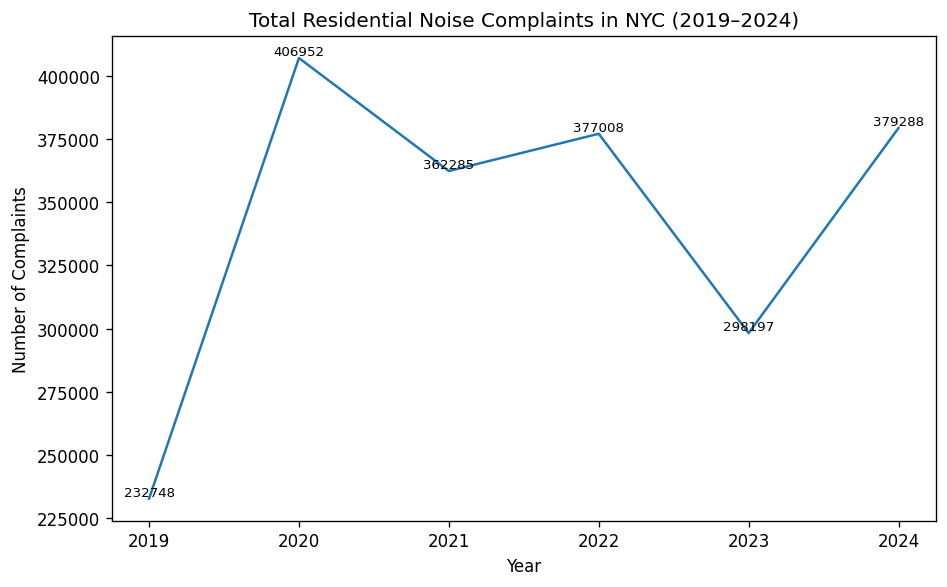

In [11]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(yearly_counts["year"], yearly_counts["count"])
ax.set_title("Total Residential Noise Complaints in NYC (2019–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Complaints")

for x, y in zip(yearly_counts["year"], yearly_counts["count"]):
    ax.text(x, y, str(y), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

## 6. Visualization: Residential Noise Complaints by Borough (2019–2024)

To understand geographic differences, I plot a separate line for each borough.
> **Do some boroughs experience faster increases in residential noise complaints?**

This helps evaluate the hypothesis that Manhattan may show the largest growth rate.


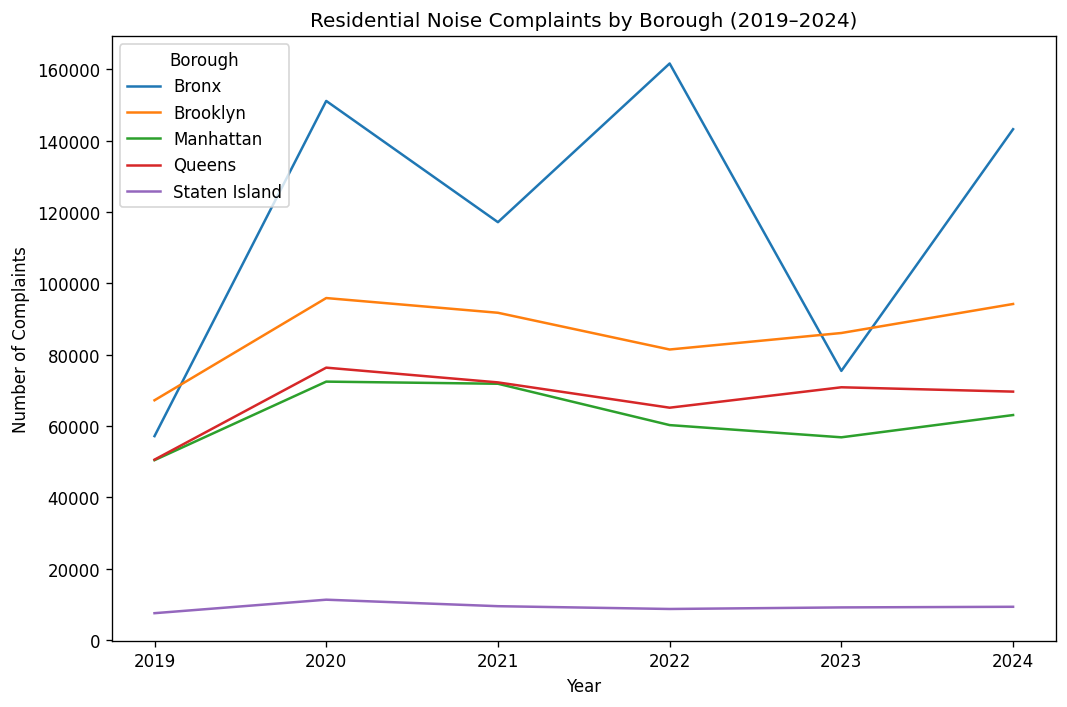

In [14]:
fig, ax = plt.subplots(figsize=(9,6))

for borough, sub in borough_year_counts.groupby("Borough"):
    ax.plot(sub["year"], sub["count"], label=borough)

ax.set_title("Residential Noise Complaints by Borough (2019–2024)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Complaints")
ax.legend(title="Borough")

plt.tight_layout()
plt.show()


## 7. Relative Growth: Which Borough Increased the Most?

This tells us how many times higher (or lower) the complaint count is
relative to 2019.


In [15]:
pivot_counts = borough_year_counts.pivot(index="year", columns="Borough", values="count")

baseline_year = 2019
baseline = pivot_counts.loc[baseline_year]

relative_growth = pivot_counts.divide(baseline)

relative_growth

Borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
year,,,,,
2019,1.000000,1.000000,1.000000,1.000000,1.000000
2020,2.644793,1.426522,1.436820,1.510230,1.504201
2021,2.049816,1.365122,1.424954,1.428453,1.261502
2022,2.828496,1.211839,1.194996,1.288089,1.157221
2023,1.320112,1.280681,1.127074,1.401345,1.215495
2024,2.506056,1.401768,1.250893,1.377305,1.239232


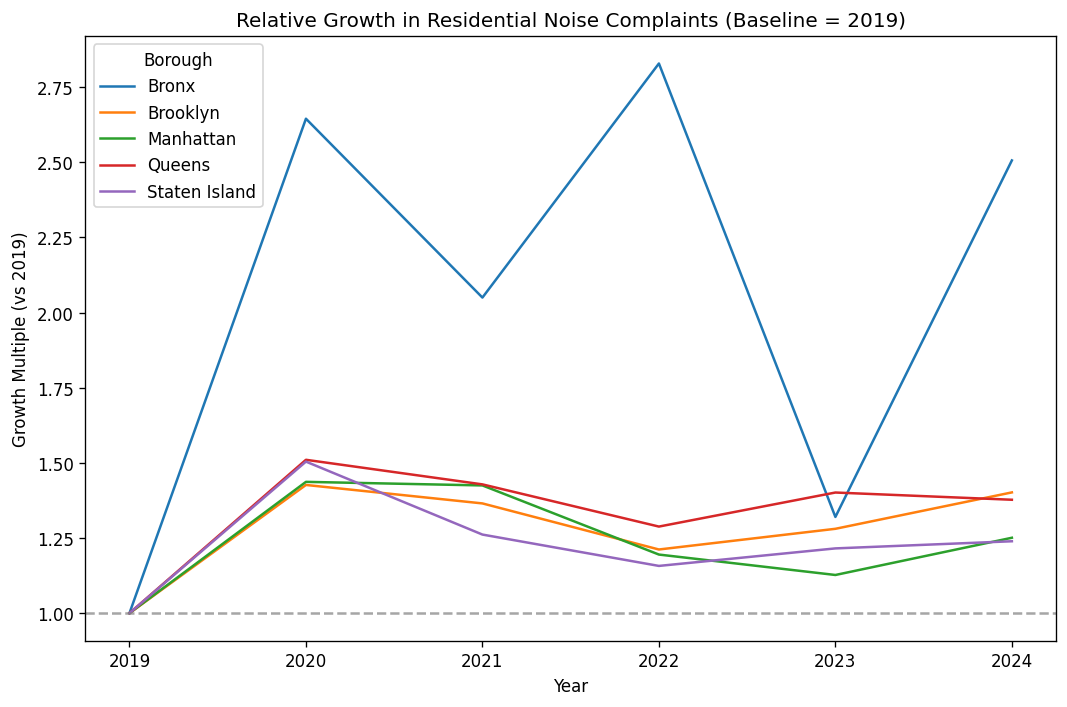

In [16]:
fig, ax = plt.subplots(figsize=(9,6))

for borough in relative_growth.columns:
    ax.plot(relative_growth.index, relative_growth[borough], label=borough)

ax.axhline(1.0, linestyle="--", color="gray", alpha=0.7)

ax.set_title("Relative Growth in Residential Noise Complaints (Baseline = 2019)")
ax.set_xlabel("Year")
ax.set_ylabel("Growth Multiple (vs 2019)")
ax.legend(title="Borough")

plt.tight_layout()
plt.show()

## 8. Interpretation and Hypothesis Evaluation

### 1. Overall Trend in Residential Noise Complaints (2019–2024)

The yearly totals show that residential noise complaints have clearly increased
relative to 2019:

- 2019: 232,748 complaints  
- 2020: 406,952 complaints
- 2021: 362,285 complaints 
- 2022: 377,008 complaints
- 2023: 298,197 complaints
- 2024: 379,288 complaints

There is a sharp spike in 2020, which coincides with COVID-19 lockdowns and
more people staying at home. Complaints remain well above the 2019 baseline
through 2021 and 2022, suggesting that changes in daily routines
continued to generate residential noise conflicts even after the
initial lockdown period. Complaints then dip in 2023 but rise again in 2024,
indicating that residential noise remains a persistent issue rather than a
one-time anomaly.

Overall, the data support the claim that residential noise complaints have
increased compared to pre-pandemic levels.

### 2. Borough-Level Differences

The borough-level plot shows that:

- **Bronx** has the highest volume of residential noise complaints throughout
  the period. Complaints increase from 57,130 in 2019 to about 151,097 in 2020
  and peak around 161,592 in 2022. By 2024, Bronx complaints (143,171) are
  still more than **2.5 times** the 2019 level.
- **Brooklyn** also shows high volumes and a clear increase: from 67,183 in
  2019 to 94,175 in 2024 (about **40%** higher than 2019).
- **Manhattan** experiences more modest growth: 50,396 complaints in 2019,
  72,410 in 2020 (about **1.4×** 2019), then dropping to 63,040 in 2024 (about **1.25×** 2019).
- **Queens** shows a similar pattern to Brooklyn, with complaints roughly
  **40–50%** higher than 2019 during most of the period.
- **Staten Island** has the lowest counts overall but still shows an increase
  from 7,499 in 2019 to 9,293 in 2024.

The relative growth plot (baseline = 2019) confirms that the **Bronx** is the
only borough where complaints more than **double** and stay above **2×** the
2019 level in several years. Other boroughs generally remain in the range of
1.2–1.5 times their 2019 levels.

### 3. Hypothesis Evaluation

**Original hypothesis:**  
“Residential noise complaints have increased significantly since 2019, with Manhattan experiencing the largest growth rate due to population density and multi-unit residential buildings.”

Based on the result after analyzing the data, hypothesis correctly anticipates an overall rise in residential
noise complaints. However, it misidentifies the borough driving the strongest growth.
The Bronx, rather than Manhattan, appears to be the primary hotspot for
escalating residential noise complaints during this period.

### 4. Limitations and Possible Extensions

Several limitations should be noted:

- 311 complaint data reflect self reported noise, which depends on a lot of outside factors. Therefore, it does not perfectly measure true noise levels.
- Aggregation at the borough-year level might hide neighborhood-level and seasonal patterns.

Possible extensions:

- Normalizing complaints by borough population or number of households to
  compare rates rather than raw counts.
- Examining neighborhood-level data or time-of-day patterns.
- Comparing residential noise complaints with other 311 categories to see
  whether the pandemic-era spike is specific to noise or part of a broader
  reporting shift.